# 9) CERAD Style CNN Scores

Modify the CNN scoring strategy for the confidence heatmaps. Original approach was to do blob detection on confidence heatmaps and divide the count of blobs by the number of pixels containing tissue (calculated by thresholding strategy on the image).

Of interest is to generate these scores for small isolated regions of the images, which is similar to how pathologist score CERAD. In the traditional approach the pathologist only have a small field of view or FOV (viewed under a microscope) which they use for analyzing plaque burden. We want to know if generating scores in this fashion yields similar or different results then using the whole tissue region. Pathologist by protocol only assess the densest FOV, which we can identify here. We will call this strategy one.

In [209]:
%reset -f
# cell to load required data and imports
import matplotlib.pyplot as plt
from os.path import join as oj
import imageio
import numpy as np
import pandas as pd
import sys
import os
from collections import namedtuple
from tqdm import tqdm_notebook as tqdm
from scipy.stats import spearmanr
from skimage.transform import resize
from PIL import Image, ImageDraw
sys.path.append('..')
from modules import heatmap_analysis as ha, plotting

blob_mask_dir = '/mnt/data/outputs/blob_masks/'
fov_scores_dir = '/mnt/data/outputs/fov_scores/'
data_path = '/mnt/AB_Plaque_Box/CSVs/Emory_data.csv'
labels = ('cored', 'diffuse', 'caa')
fov_labels = ('cored_densest_fov', 'diffuse_densest_fov', 'caa_densest_fov')

#### Score FOV regions

Slide a FOV region accross the blob mask (confidence heatmaps processed for blob detection) and score each FOV region by unique blobs in the FOV divide by the FOV area.

(1) Ideally the FOV should mostly be containing tissue content and avoid non-tissue space. In reality the tissue threshold method is rife with noise and using this as a determination of tissue region would yield noisy results. Alternatively we assume that all region image is tissue and slide a small analysis region across the image with a small stride and report the highest blob count in the region regardless of what is under. 

(2) The best solution, though not done here, would be to carefully annotate the entire tissue region and use that as ground truth for what pixels contain tissue and what don't.

(3) The output of this will be a csv file for each image containing columns: x, y, fov height, fov width, plaque type, count. Only FOV with at least one plaque will be saved, all others are assumed to be 0.

In [ ]:
# run for all images and save csv to a fov_scores dir
# run using default FOV shape of 128 by 128 and stride of 16
os.makedirs(fov_scores_dir, exist_ok=True)

for blob_mask_file in tqdm(os.listdir(blob_mask_dir)):
    save_path = oj(fov_scores_dir, blob_mask_file.replace('.npy', '.csv'))
    
    # don't run if save path already exists - might mean it was previously run
    if not os.path.isfile(save_path):
        ha.conf_heatmap_fov_scores(oj(blob_mask_dir, blob_mask_file), save_path, fov_shape=(251, 251))

#### Tissue CNN vs FOV CNN score correlations

For the average of the n densest FOV (highest CNN scores) plot the correlation between that CNN score and the original CNN score (whole tissue). 

Side-by-side plot the box plots of the CNN scores grouped by CERAD-like categories.

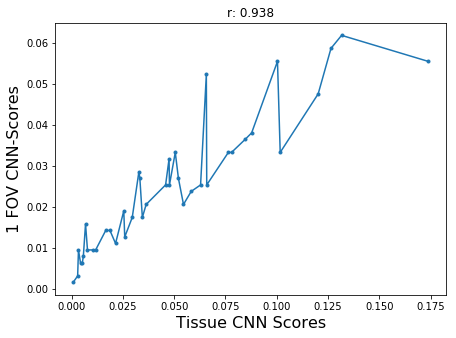

None count: 10
Sparse count: 13
Moderate count: 14
Frequent count: 3
None, Sparse: p-value of 0.0006234796445317928
None, Moderate: p-value of 0.00013742937406463623
None, Frequent: p-value of 7.340723963920501e-07
Sparse, Moderate: p-value of 0.3927882679652235
Sparse, Frequent: p-value of 0.010854181402710517
Moderate, Frequent: p-value of 0.0486174060324722


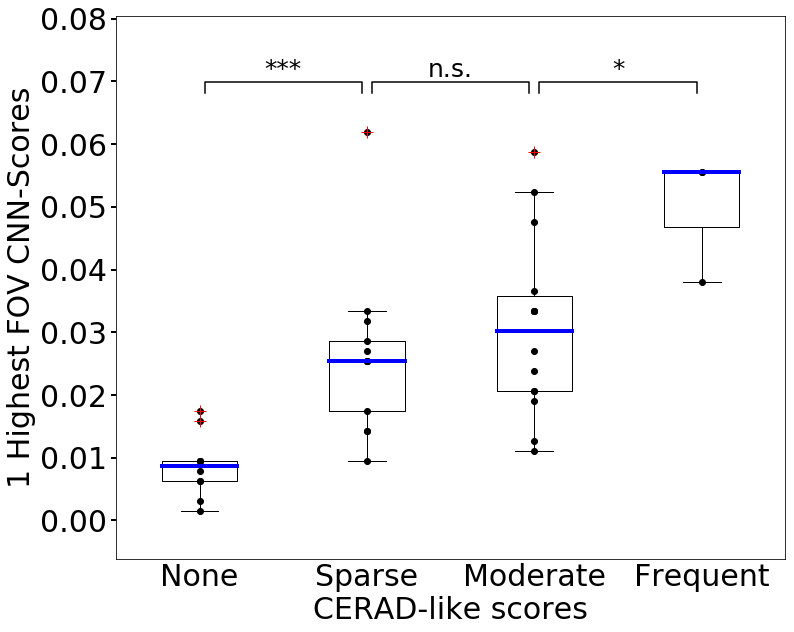

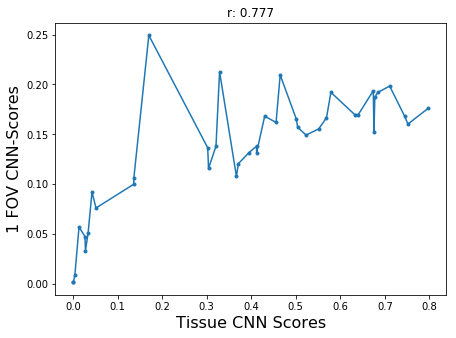

None count: 6
Sparse count: 3
Moderate count: 3
Frequent count: 28
None, Sparse: p-value of 0.4788940324513248
None, Moderate: p-value of 0.012972451245501938
None, Frequent: p-value of 3.6969857387218726e-08
Sparse, Moderate: p-value of 0.04859542838384026
Sparse, Frequent: p-value of 0.00010035455327331366
Moderate, Frequent: p-value of 0.07258272332620017


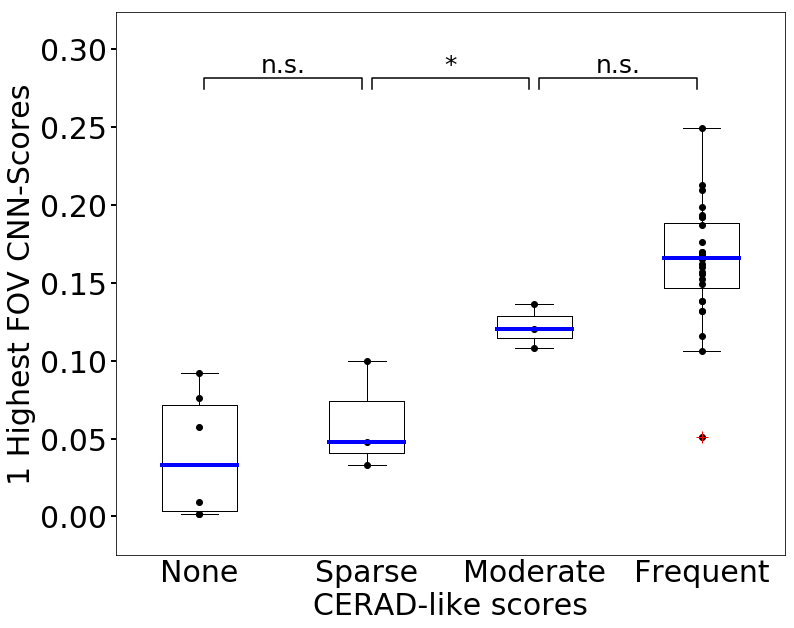

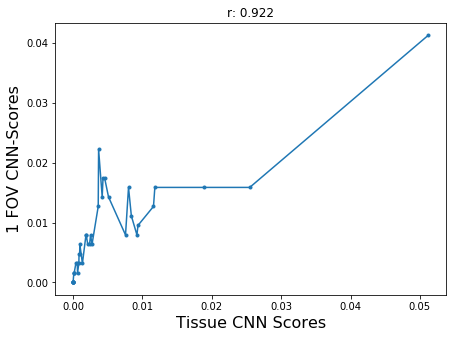

None count: 19
Sparse count: 5
Moderate count: 6
Frequent count: 10
None, Sparse: p-value of 0.9361184012032746
None, Moderate: p-value of 0.061942287874378374
None, Frequent: p-value of 0.0007470605146574919
Sparse, Moderate: p-value of 0.05349488203493332
Sparse, Frequent: p-value of 0.026480045021569285
Moderate, Frequent: p-value of 0.19627450955458306


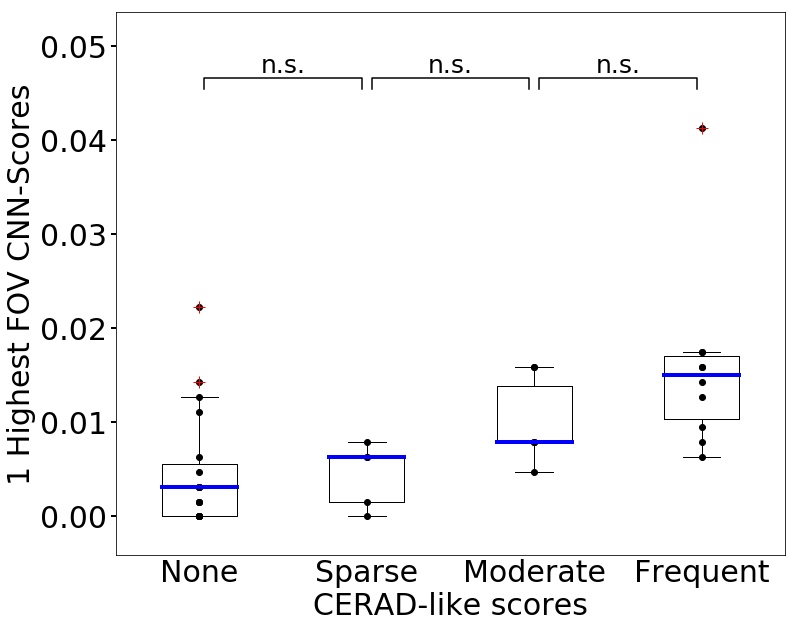

In [228]:
# load main data file
df = pd.read_csv(data_path)
Rectangle = namedtuple('Rectangle', 'xmin ymin xmax ymax')


def area(a, b):  # returns None if rectangles don't intersect
    dx = min(a.xmax, b.xmax) - max(a.xmin, b.xmin)
    dy = min(a.ymax, b.ymax) - max(a.ymin, b.ymin)
    if (dx>=0) and (dy>=0):
        return dx*dy
    else:
        return 0


def fov_correlation(data_path, fov_dir, n=1, plot=False):
    """Plot correlation of the average n denset FOV in each image vs the whole tissue image.
    
    :param data_path : str
        path to data file for case info, CERAD categories, and whole tissue scores
    :param fov_dir : str
        the dir containing the fov csv files for each case
    :param n : int (default of 1)
        the n highest FOV scores to use
    """
    labels=('cored', 'diffuse', 'caa')
    fov_labels = ('cored_densest_fov', 'diffuse_densest_fov', 'caa_densest_fov')
    tissue_labels = ('tissue_cored_score', 'tissue_diffuse_score', 'tissue_caa_score')
    category_labels = ('Cored_MTG', 'Diffuse_MTG', 'CAA_MTG')
    df = pd.read_csv(data_path)
    
    # add a column for densest FOV count for each case's plaques types (cored, diffuse, caa)
    densest_scores = [[], [], []]

    for idx, row in df.iterrows():
        # load the fov scores for this case
        fov_df = pd.read_csv(oj(fov_scores_dir, row['WSI_ID'] + '.csv'))

        for i, label in enumerate(labels):
            # subset each type of plaque
            df_subset = fov_df[fov_df['label']==label].reset_index(drop=True)
            
            # sort by counts
            df_subset = df_subset.sort_values(by=['count'], ascending=False).reset_index(drop=True)
            
            # df subset is 0 then just return 0
            if len(df_subset) == 0:
                densest_scores[i].append(0)
                continue
                            
            # take the n highest non-overlapping counts
            x, y = df_subset.loc[0, 'x'], df_subset.loc[0, 'y']
            w, h = df_subset.loc[0, 'width'], df_subset.loc[0, 'height']
            scores = [df_subset.loc[0, 'count'] * 100 / (w * h)]
            coords = [Rectangle(x, y, x + w, y + h)]
            
            for j in range(1, len(df_subset)):
                # if we already have the top n counts, then stop
                if len(scores) == n:
                    break
                    
                # else check the this region to make sure it does not overlap with previous regions
                x, y = df_subset.loc[j, 'x'], df_subset.loc[j, 'y']
                w, h = df_subset.loc[j, 'width'], df_subset.loc[j, 'height']
                r = Rectangle(x, y, x + w, y + h)
                
                # for all already region check
                flag = False
                for coord in coords:
                    if area(coord, r) != 0:
                        flag = True
                        break
                
                # if flag did not change to true then this region does not overlap, add it
                if not flag:
                    coords.append(r)
                    scores.append(df_subset.loc[j, 'count'] * 100 / (w * h))
                    
            # convert scores to average and append to denset list - note that there may be less than n 
            # entries if not enough non-overlapping regions
            densest_scores[i].append(sum(scores) / len(scores))
            
    # add the densest fov column (scores)
    for i in range(3):
        df[fov_labels[i]] = densest_scores[i]
        
    # sort the tissue scores and densest FOV scores and plot against each other
    rhos = []
    for i in range(3):
        tissue_scores = df[tissue_labels[i]].tolist()
        fov_scores = df[fov_labels[i]].tolist()
        
        # return spearman correlation with the CERAD like scores
        rho, p = spearmanr(fov_scores, df[category_labels[i]].tolist())
        rhos.append(rho)
        
        # calaculate spearman correlation between tissue and fov scores
        rho, p = spearmanr(tissue_scores, fov_scores)
#       
        
        # sort the lists together before plotting
        tissue_scores, fov_scores = (list(t) for t in zip(*sorted(zip(tissue_scores, fov_scores))))
        
        if plot:
            plt.figure(figsize=(7, 5))
            plt.plot(tissue_scores, fov_scores, '.-')
            plt.xlabel('Tissue CNN Scores', fontsize=16)
            plt.ylabel('{} FOV CNN-Scores'.format(n), fontsize=16)
            plt.title('r: {:0.3f}'.format(float(rho)))
            plt.show()

            x_param = {0: 'None', 1: 'Sparse', 2: 'Moderate', 3: 'Frequent'}
            plotting.plot_cnn_scores(df, category_labels[i], fov_labels[i], x_param, 
                                     ylabel='{} Highest FOV CNN-Scores'.format(n),
                                     xlabel='CERAD-like scores')
            
        
    return rhos
        
        
output = []
rhos = fov_correlation(data_path, fov_scores_dir, n=1, plot=True)

#### Plot the effect of increasing FOV regions used to estimate CNN score vs Whole Tissue

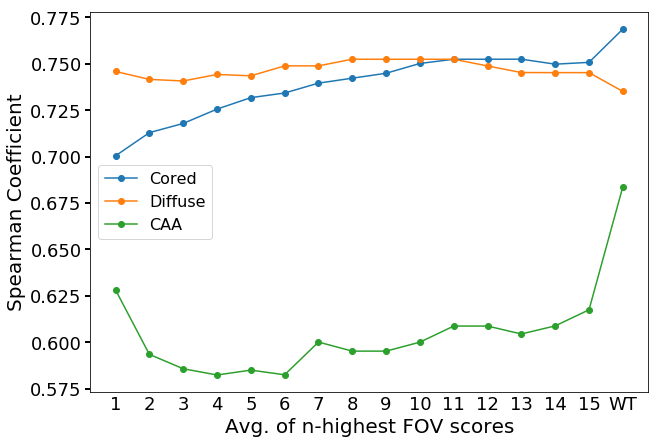

In [232]:
# for each plauqe get the spearman correlation coeff between the n average FOV vs CERAD categories
output = []
N = 16
for n in range(1, N):
    rhos = fov_correlation(data_path, fov_scores_dir, n=n)
    output.append(rhos)
    
output = np.array(output)

# add the spearman corrrelation coeff for whole tissue as last point
r_cored, p = spearmanr(df['Cored_MTG'].tolist(), df['tissue_cored_score'].tolist())
r_diffuse, p = spearmanr(df['Diffuse_MTG'].tolist(), df['tissue_diffuse_score'].tolist())
r_caa, p = spearmanr(df['CAA_MTG'].tolist(), df['tissue_caa_score'].tolist())
r_tissue = [r_cored, r_diffuse, r_caa]

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
x = list(range(1, N+1))
for i in range(3):
    fov_scores = list(output[:, i]) + [r_tissue[i]]
    ax.plot(x, fov_scores, 'o-')
    ax.set_xticks(x)
    x_tick_labels = [str(_x) for _x in x[:-1]] + ['WT']
    ax.set_xticklabels(x_tick_labels)
ax.legend(['Cored', 'Diffuse', 'CAA'], fontsize=16)
ax.set_ylabel('Spearman Coefficient', fontsize=20)
ax.xaxis.set_tick_params(labelsize=18, size=0, width=2)
ax.yaxis.set_tick_params(labelsize=18, size=5, width=2)
ax.set_xlabel('Avg. of n-highest FOV scores', fontsize=20)

fig.savefig('/mnt/data/figures/fov_correlations.png', bbox_inches='tight', dpi=300)
plt.show()

#### Use on example to show the three top FOV regions
Re-using a lot of my code above.

In [197]:
Rectangle = namedtuple('Rectangle', 'xmin ymin xmax ymax')

def area(a, b):  # returns None if rectangles don't intersect
    dx = min(a.xmax, b.xmax) - max(a.xmin, b.xmin)
    dy = min(a.ymax, b.ymax) - max(a.ymin, b.ymin)
    if (dx>=0) and (dy>=0):
        return dx*dy
    else:
        return 0

In [195]:
fov_df = pd.read_csv('/mnt/data/outputs/fov_scores/A05-132_AB_1D.csv')
hm = np.load('/mnt/data/outputs/heatmaps_emory/A05-132_AB_1D.npy')[0]
im = imageio.imread('/mnt/data/figures/A05-132_AB_1D_thumbnail.jpeg')
im = resize(im, hm.shape)

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [198]:
# just show a cored example
df_subset = fov_df[fov_df['label']=='cored'].reset_index(drop=True)

# sort by counts
df_subset = df_subset.sort_values(by=['count'], ascending=False).reset_index(drop=True)

# take the n highest non-overlapping counts
x, y = df_subset.loc[0, 'x'], df_subset.loc[0, 'y']
w, h = df_subset.loc[0, 'width'], df_subset.loc[0, 'height']
scores = [df_subset.loc[0, 'count'] * 100 / (w * h)]
coords = [Rectangle(x, y, x + w, y + h)]
            
n = 3
for j in range(1, len(df_subset)):
    # if we already have the top n counts, then stop
    if len(scores) == n:
        break
                    
    # else check the this region to make sure it does not overlap with previous regions
    x, y = df_subset.loc[j, 'x'], df_subset.loc[j, 'y']
    w, h = df_subset.loc[j, 'width'], df_subset.loc[j, 'height']
    r = Rectangle(x, y, x + w, y + h)
                
    # for all already region check
    flag = False
    for coord in coords:
        if area(coord, r) != 0:
            flag = True
            break
                
    # if flag did not change to true then this region does not overlap, add it
    if not flag:
        coords.append(r)
        scores.append(df_subset.loc[j, 'count'] * 100 / (w * h))

In [227]:
def draw_rectangle(draw, coordinates, color, width=1):
    for i in range(width):
        rect_start = (coordinates[0][0] - i, coordinates[0][1] - i)
        rect_end = (coordinates[1][0] + i, coordinates[1][1] + i)
        draw.rectangle((rect_start, rect_end), outline = color)

# draw the regions on the image
im_copy = Image.fromarray((im * 255).astype(np.uint8))
draw = ImageDraw.Draw(im_copy)

outline_width = 10
colors = ['red', 'orange', 'green']

for i, coord in enumerate(coords):
    draw_rectangle(draw, [(coord.xmin, coord.ymin), (coord.xmax, coord.ymax)], color=colors[i],
                  width=outline_width)
del draw
    
im_copy.save('/mnt/data/figures/fov_boxes.png')